In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [166]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from sklearn.preprocessing import OneHotEncoder

In [4]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["question", "intent"])
    df.dropna()
    print(df.head())
    intent = df["intent"]
    unique_intent = list(set(intent))
    question = list(df["question"])
    return (intent, unique_intent, question)

In [44]:
intent, unique_intent, question = load_dataset("data_complete_final.csv")

            question  intent
0                 yo  gen_hi
1               Heya  gen_hi
2            Namaste  gen_hi
3                Hey  gen_hi
4  To great see you!  gen_hi


In [45]:
print(question[100:105])
print(unique_intent)

['Am who I chatting with?', "What ' s your? name", 'Should what I say your as name?', 'Tell me name your?', 'What are called you?']
['gen_bye', 'spe_credits_get_how', 'spe_alute_purpose', 'gen_fund', 'spe_alute_credits', 'gen_name', 'spe_proj_req_appr', 'spe_admin_who', 'spe_alutoze_get_how', 'gen_who_made', 'spe_alute_acc_free', 'spe_alute_domains', 'spe_proj_limit', 'gen_social_media', 'spe_why_alute', 'spe_alutoze_what', 'gen_who_you', 'gen_query', 'gen_thanks', 'gen_help', 'spe_what_alute_is', 'gen_bot', 'spe_credits_actual_resp', 'gen_how_you', 'gen_contact_info', 'spe_alute_since_when', 'spe_git_why', 'spe_admin_purpose', 'gen_hi', 'spe_proj_own', 'spe_credits_use_how', 'gen_human', 'spe_alutoz_aft_credits', 'spe_data_secure', 'gen_collab']


In [46]:
def cleaning(question):
    words = []
    for s in question:
        clean = re.sub(r'[^a-z A-Z]', " ", s)
        w = word_tokenize(clean)
        #stemming
        words.append([i.lower() for i in w])
    
    return words  

In [47]:
cleaned_words = cleaning(question)
print(len(cleaned_words))

18513


In [48]:
print(cleaned_words[:8])

[['yo'], ['heya'], ['namaste'], ['hey'], ['to', 'great', 'see', 'you'], ['ssup'], ['whatup'], ['yo']]


In [49]:
def create_tokenizer(words, filters = '!"#$%&*+,-./:;<=>?@[\]^`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [50]:
def max_length(words):
    return(len(max(words, key = len)))

In [51]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 3507 and Maximum length = 26


In [52]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [53]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)

In [54]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [55]:
padded_doc = padding_doc(encoded_doc, max_length)

In [56]:
padded_doc[115:118]

array([[ 10,   9,   2, 154,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,  10,   9, 199,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 10,   9,   2, 388,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [57]:
print("Shape of padded docs = ",padded_doc.shape)

Shape of padded docs =  (18513, 26)


In [58]:
output_tokenizer = create_tokenizer(unique_intent)

In [59]:
output_tokenizer.word_index

{'gen_bye': 1,
 'spe_credits_get_how': 2,
 'spe_alute_purpose': 3,
 'gen_fund': 4,
 'spe_alute_credits': 5,
 'gen_name': 6,
 'spe_proj_req_appr': 7,
 'spe_admin_who': 8,
 'spe_alutoze_get_how': 9,
 'gen_who_made': 10,
 'spe_alute_acc_free': 11,
 'spe_alute_domains': 12,
 'spe_proj_limit': 13,
 'gen_social_media': 14,
 'spe_why_alute': 15,
 'spe_alutoze_what': 16,
 'gen_who_you': 17,
 'gen_query': 18,
 'gen_thanks': 19,
 'gen_help': 20,
 'spe_what_alute_is': 21,
 'gen_bot': 22,
 'spe_credits_actual_resp': 23,
 'gen_how_you': 24,
 'gen_contact_info': 25,
 'spe_alute_since_when': 26,
 'spe_git_why': 27,
 'spe_admin_purpose': 28,
 'gen_hi': 29,
 'spe_proj_own': 30,
 'spe_credits_use_how': 31,
 'gen_human': 32,
 'spe_alutoz_aft_credits': 33,
 'spe_data_secure': 34,
 'gen_collab': 35}

In [60]:
encoded_output = encoding_doc(output_tokenizer, intent)

In [61]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [62]:
encoded_output.shape

(18513, 1)

In [63]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [64]:
output_one_hot = one_hot(encoded_output)

In [65]:
output_one_hot.shape

(18513, 35)

In [66]:
from sklearn.model_selection import train_test_split

In [189]:
x_train, x_val, y_train, y_val = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2)

In [190]:
print("Shape of train_X = %s and train_Y = %s" % (x_train.shape, y_train.shape))
print("Shape of val_X = %s and val_Y = %s" % (x_val.shape, y_val.shape))

Shape of train_X = (14810, 26) and train_Y = (14810, 35)
Shape of val_X = (3703, 26) and val_Y = (3703, 35)


In [191]:
model=Sequential()
model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = True))
#model.add(GRU(128,return_sequences=True))
#model.add(Bidirectional(LSTM(128,return_sequences=True)))
#model.add(GRU(128,return_sequences=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(128, activation = "relu"))    ###
model.add(Dropout(0.5))
model.add(Dense(96, activation = "relu"))    ###
model.add(Dropout(0.3))
model.add(Dense(35, activation = "softmax"))

In [192]:
opt = SGD(lr=0.01, momentum=0.9)
#model.compile(loss='kullback_leibler_divergence', optimizer='adam', metrics=['accuracy'])
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [193]:
filename = 'test_single_LSTM_layer.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#history = model.fit(x_train, y_train, epochs = 100, batch_size = 8, validation_split=0.2, verbose=1, callbacks=[checkpoint])
history = model.fit(x_train, y_train, epochs = 20, batch_size = 8, validation_data= (x_val, y_val), verbose=1,callbacks=[checkpoint])

Epoch 1/20
1852/1852 [==============================] - 30s 13ms/step - loss: 2.6627 - accuracy: 0.2242 - val_loss: 0.4815 - val_accuracy: 0.8512

Epoch 00001: val_loss improved from inf to 0.48151, saving model to test_single_LSTM_layer.h5
Epoch 2/20
1852/1852 [==============================] - 24s 13ms/step - loss: 0.5692 - accuracy: 0.8116 - val_loss: 0.2266 - val_accuracy: 0.9395

Epoch 00002: val_loss improved from 0.48151 to 0.22663, saving model to test_single_LSTM_layer.h5
Epoch 3/20
1852/1852 [==============================] - 23s 12ms/step - loss: 0.2447 - accuracy: 0.9283 - val_loss: 0.1679 - val_accuracy: 0.9590

Epoch 00003: val_loss improved from 0.22663 to 0.16789, saving model to test_single_LSTM_layer.h5
Epoch 4/20
1852/1852 [==============================] - 23s 12ms/step - loss: 0.1528 - accuracy: 0.9589 - val_loss: 0.1440 - val_accuracy: 0.9654

Epoch 00004: val_loss improved from 0.16789 to 0.14396, saving model to test_single_LSTM_layer.h5
Epoch 5/20
1852/1852 [==

In [194]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 26, 128)           448896    
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 256)               263168    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 96)                12384     
_________________________________________________________________
dropout_10 (Dropout)         (None, 96)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 35)               

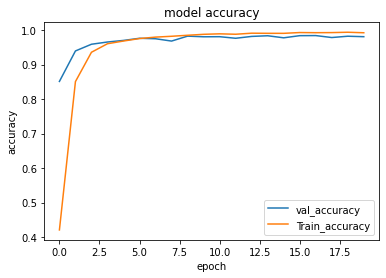

In [195]:
def plotloss(history):
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['val_accuracy', 'Train_accuracy'], loc = 'lower right')
    plt.show()
    
plotloss(history)

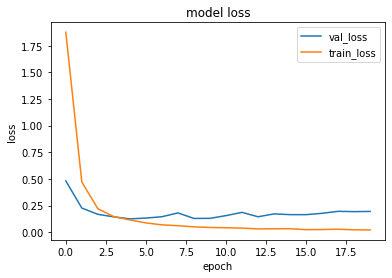

In [196]:
def plotloss1(history):
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['val_loss', 'train_loss'], loc = 'best')
    plt.show()
    
plotloss1(history)

In [197]:
_,acc=model.evaluate(x_val,y_val)
print(acc*100)

116/116 [==============================] - 1s 6ms/step - loss: 0.1950 - accuracy: 0.9808
98.08263778686523


In [76]:
model = load_model("test3.h5")

In [134]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]'," ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    #print(test_word)            ##
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))
    
    test_ls = np.array(test_ls).reshape(1, len(test_ls))
 
    x = padding_doc(test_ls, max_length)
  
    pred = model.predict(x)
  
    return pred 

In [140]:
def get_final_output(pred, classes):
    predictions = pred[0]
 
    classes = np.array(classes)
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    pred_intent=classes[0]
 
    #for i in range(pred.shape[1]):
    #    print("%s has confidence = %s" % (classes[i], (predictions[i])))
    return pred_intent


In [79]:
#def user():
#    text=input('Enter your query : ')
#    pred = predictions(text)
#    get_final_output(pred,unique_intent)

In [ ]:
#user()

In [125]:
df1=pd.read_csv("responses.csv")

In [126]:
df1.head()

,gen_hi,gen_how_you,gen_who_you,gen_name,gen_bot,gen_human,gen_who_made,gen_help,gen_query,gen_social_media,...,spe_proj_own,spe_proj_limit,spe_git_why,spe_credits_use_how,spe_credits_actual_resp,spe_alutoz_aft_credits,spe_why_alute,spe_alute_acc_free,spe_data_secure,spe_admin_purpose
0,Hi!,"I am good, thanks for asking!","I am a bot, here to help.",You are talking to Alute-bot,Indeed.,No I am not a human,I was build by the same people who built this ...,"Sure, what do you want me to do?",Shoot away!,<insta_handle>,...,spe_proj_own,spe_proj_limit,spe_git_why,spe_credits_use_how,spe_credits_actual_resp,spe_alutoz_aft_credits,spe_why_alute,spe_alute_acc_free,spe_data_secure,spe_admin_purpose
1,Hello!,"I am great, thanks!",I am a chatbot.,My name is Alute-bot,"Yes, I am a bot",Certainly not,By an amazing team who made Alute,That's my job! What do you need help with,You can ask me anything,<twitter_handle>,...,spe_proj_own,spe_proj_limit,spe_git_why,spe_credits_use_how,spe_credits_actual_resp,spe_alutoz_aft_credits,spe_why_alute,spe_alute_acc_free,spe_data_secure,spe_admin_purpose
2,Hey!,Never better!,I am an AI powered bot.,Alute-bot is the name,Certainly not human,"Nope, I am a bot",The Alute team created me,provide help is what I do,What's your question,"Why, are you gonna stalk me?",...,spe_proj_own,spe_proj_limit,spe_git_why,spe_credits_use_how,spe_credits_actual_resp,spe_alutoz_aft_credits,spe_why_alute,spe_alute_acc_free,spe_data_secure,spe_admin_purpose
3,Hola!,"Perfectly fine, thanks!",Chatbot. That's what I am.,name? It's Alute-bot,You guessed it right,Human? Meh.,I am brought to you by the makers of Alute,"Definitely, by any means possible",Ask me anything!,"Why, are you gonna stalk me?",...,spe_proj_own,spe_proj_limit,spe_git_why,spe_credits_use_how,spe_credits_actual_resp,spe_alutoz_aft_credits,spe_why_alute,spe_alute_acc_free,spe_data_secure,spe_admin_purpose


In [89]:
import random

In [127]:
df1=pd.DataFrame(df1)


In [131]:
print(random.choice(df1.iloc[:,1]))

I am good, thanks for asking!


In [132]:
A=list(df1.columns)

In [136]:
def F1():
    print('bot: ',random.choice(df1.iloc[:,0]))
def F2():
    print('bot: ',random.choice(df1.iloc[:,1]))
def F3():
    print('bot: ',random.choice(df1.iloc[:,2]))
def F4():
    print('bot: ',random.choice(df1.iloc[:,3]))
def F5():
    print('bot: ',random.choice(df1.iloc[:,4]))
def F6():
    print('bot: ',random.choice(df1.iloc[:,5]))
def F7():
    print('bot: ',random.choice(df1.iloc[:,6]))
def F8():
    print('bot: ',random.choice(df1.iloc[:,7]))
def F9():
    print('bot: ',random.choice(df1.iloc[:,8]))
def F10():
    print('bot: ',random.choice(df1.iloc[:,9]))
def F11():
    print('bot: ',random.choice(df1.iloc[:,10]))
def F12():
    print('bot: ',random.choice(df1.iloc[:,11]))
def F13():
    print('bot: ',random.choice(df1.iloc[:,12]))
def F14():
    print('bot: ',random.choice(df1.iloc[:,13]))
def F15():
    print('bot: ',random.choice(df1.iloc[:,14]))
def F16():
    print('bot: ',random.choice(df1.iloc[:,15]))
def F17():
    print('bot: ',random.choice(df1.iloc[:,16]))
def F18():
    print('bot: ',random.choice(df1.iloc[:,17]))
def F19():
    print('bot: ',random.choice(df1.iloc[:,18]))
def F20():
    print('bot: ',random.choice(df1.iloc[:,19]))
def F21():
    print('bot: ',random.choice(df1.iloc[:,20]))
def F22():
    print('bot: ',random.choice(df1.iloc[:,21]))
def F23():
    print('bot: ',random.choice(df1.iloc[:,22]))
def F24():
    print('bot: ',random.choice(df1.iloc[:,23]))
def F25():
    print('bot: ',random.choice(df1.iloc[:,24]))
def F26():
    print('bot: ',random.choice(df1.iloc[:,25]))
def F27():
    print('bot: ',random.choice(df1.iloc[:,26]))
def F28():
    print('bot: ',random.choice(df1.iloc[:,27]))
def F29():
    print('bot: ',random.choice(df1.iloc[:,28]))
def F30():
    print('bot: ',random.choice(df1.iloc[:,29]))
def F31():
    print('bot: ',random.choice(df1.iloc[:,30]))
def F32():
    print('bot: ',random.choice(df1.iloc[:,31]))
def F33():
    print('bot: ',random.choice(df1.iloc[:,32]))
def F34():
    print('bot: ',random.choice(df1.iloc[:,33]))
def F35():
    print('bot: ',random.choice(df1.iloc[:,34]))


In [153]:
def user_output():
    for i in range(5):
        text=input('\nYou: ')
        if text == 'quit':
            print('bye')
            break
        elif text == '':
            print("Please enter a valid response")
        else : 
            pred = predictions(text)
            if get_final_output(pred, unique_intent) == A[0]:
                F1()
            elif get_final_output(pred, unique_intent) == A[1]:
                F2()
            elif get_final_output(pred, unique_intent) == A[2]:
                F3()
            elif get_final_output(pred, unique_intent) == A[3]:
                F4()
            elif get_final_output(pred, unique_intent) == A[4]:
                F5()
            elif get_final_output(pred, unique_intent) == A[5]:
                F6()
            elif get_final_output(pred, unique_intent) == A[6]:
                F7()
            elif get_final_output(pred, unique_intent) == A[7]:
                F8()
            elif get_final_output(pred, unique_intent) == A[8]:
                F9()
            elif get_final_output(pred, unique_intent) == A[9]:
                F10()
            elif get_final_output(pred, unique_intent) == A[10]:
                F11()
            elif get_final_output(pred, unique_intent) == A[11]:
                F12()
            elif get_final_output(pred, unique_intent) == A[12]:
                F13()
            elif get_final_output(pred, unique_intent) == A[13]:
                F14()
            elif get_final_output(pred, unique_intent) == A[14]:
                F15()
            elif get_final_output(pred, unique_intent) == A[15]:
                F16()
            elif get_final_output(pred, unique_intent) == A[16]:
                F17()
            elif get_final_output(pred, unique_intent) == A[17]:
                F18()
            elif get_final_output(pred, unique_intent) == A[18]:
                F19()
            elif get_final_output(pred, unique_intent) == A[19]:
                F20()
            elif get_final_output(pred, unique_intent) == A[20]:
                F21()
            elif get_final_output(pred, unique_intent) == A[21]:
                F22()
            elif get_final_output(pred, unique_intent) == A[22]:
                F23()
            elif get_final_output(pred, unique_intent) == A[23]:
                F24()
            elif get_final_output(pred, unique_intent) == A[24]:
                F25()
            elif get_final_output(pred, unique_intent) == A[25]:
                F26()
            elif get_final_output(pred, unique_intent) == A[26]:
                F27()
            elif get_final_output(pred, unique_intent) == A[27]:
                F28()
            elif get_final_output(pred, unique_intent) == A[28]:
                F29()
            elif get_final_output(pred, unique_intent) == A[29]:
                F30()
            elif get_final_output(pred, unique_intent) == A[30]:
                F31()
            elif get_final_output(pred, unique_intent) == A[31]:
                F32()
            elif get_final_output(pred, unique_intent) == A[32]:
                F33()
            elif get_final_output(pred, unique_intent) == A[33]:
                F34()
            elif get_final_output(pred, unique_intent) == A[34]:
                F35()
            else:
                print("Please enter a valid response")



In [155]:
user_output()


You: hello
bot:  Hello!

You: what is your name?
bot:  name? It's Alute-bot

You: what are alutoze?
bot:  spe_alutoze_what

You: how can I use my credits?
bot:  spe_credits_use_how

You: how can I contact you?
bot:  You can contact us via <mail_id>
